# Art Style Transfer Model

## Step 1: Import libraries and model

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing import image as kp_image
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.applications import vgg19

## Step 2: Load images

Function to load and preprocess images

In [2]:
def load_img(path_to_img, max_dim = 512):
    img = kp_image.load_img(path_to_img)
    img = kp_image.img_to_array(img)

    # Scale the image
    img = tf.image.resize(img, (max_dim, max_dim))
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    img = np.copy(img)  # Make the array writable
    img = vgg19.preprocess_input(img)
    return img

In [3]:
def deprocess_img(processed_img):
    x = processed_img.copy()
    if len(x.shape) == 4:
        x = np.squeeze(x, 0)  # Remove batch dimension

    # Reverse the VGG19 preprocessing
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]  # Convert from BGR to RGB
    x = np.clip(x, 0, 255).astype('uint8')
    return x


In [4]:
# Load the pre-trained VGG19 model for feature extraction
def get_model():
    vgg = vgg19.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    # Content and style layer definitions
    content_layers = ['block5_conv2']  # Layer for content extraction
    style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']  # Style layers

    outputs = [vgg.get_layer(name).output for name in style_layers + content_layers]
    model = models.Model([vgg.input], outputs)
    return model, style_layers, content_layers


In [5]:
# Compute the content loss
def content_loss(base_content, target):
    return tf.reduce_mean(tf.square(base_content - target))

In [6]:
# Compute the style loss (based on the Gram matrix)
def gram_matrix(input_tensor):
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    return gram / tf.cast(n, tf.float32)

def style_loss(style, target):
    S = gram_matrix(style)
    T = gram_matrix(target)
    return tf.reduce_mean(tf.square(S - T))

In [7]:
# Compute the total loss (content + style loss)
def compute_loss(model, loss_weights, init_image, gram_style_features, content_features, num_style_layers, num_content_layers):
    style_weight, content_weight = loss_weights

    model_outputs = model(init_image)

    style_output_features = model_outputs[:num_style_layers]
    content_output_features = model_outputs[num_style_layers:]

    style_score = 0
    content_score = 0

    # Compute the style loss
    for target_style, comb_style in zip(gram_style_features, style_output_features):
        style_score += style_loss(target_style, comb_style[0])

    # Compute the content loss
    for target_content, comb_content in zip(content_features, content_output_features):
        content_score += content_loss(target_content, comb_content[0])

    style_score *= style_weight / num_style_layers
    content_score *= content_weight / num_content_layers

    loss = style_score + content_score
    return loss

In [15]:
var_iterations = 400

# Style transfer function
def style_transfer(content_image_path, style_image_path, num_iterations=var_iterations, style_weight=1e-2, content_weight=1e4):

    # * 20 iterations took 1m03s on my machine
    # * 400 iterations took 20m36s on my machine


    # Load content and style images
    content_image = load_img(content_image_path)
    style_image = load_img(style_image_path)

    # Initialize the target image as a copy of the content image
    target_image = tf.Variable(content_image, dtype=tf.float32)

    # Load the pre-trained VGG19 model
    model, style_layers, content_layers = get_model()

    # Extract features from style and content images
    style_outputs = model(style_image)
    content_outputs = model(content_image)

    style_features = [gram_matrix(output) for output in style_outputs[:len(style_layers)]]
    content_features = [output for output in content_outputs[len(style_layers):]]

    # Define optimizer
    optimizer = tf.optimizers.Adam(learning_rate=0.02)

    # Define loss weights
    loss_weights = (style_weight, content_weight)

    # Run optimization
    for i in range(num_iterations):
        with tf.GradientTape() as tape:
            loss = compute_loss(
                model=model,
                loss_weights=loss_weights,
                init_image=target_image,
                gram_style_features=style_features,
                content_features=content_features,
                num_style_layers=len(style_layers),
                num_content_layers=len(content_layers)
            )

        # Compute gradients and update the target image
        grad = tape.gradient(loss, target_image)
        optimizer.apply_gradients([(grad, target_image)])

        # Clip target image to valid pixel values
        target_image.assign(tf.clip_by_value(target_image, 0.0, 255.0))

        # Display progress
        if i % 100 == 0:
            print(f"Iteration: {i}, Total loss: {loss}")

    # Deprocess and return the final stylized image
    final_img = deprocess_img(target_image.numpy())
    return final_img


Iteration: 0, Total loss: 1.6482866772920238e+20
Iteration: 100, Total loss: 1.648287556901326e+20
Iteration: 200, Total loss: 1.6482873809794656e+20
Iteration: 300, Total loss: 1.648287205057605e+20


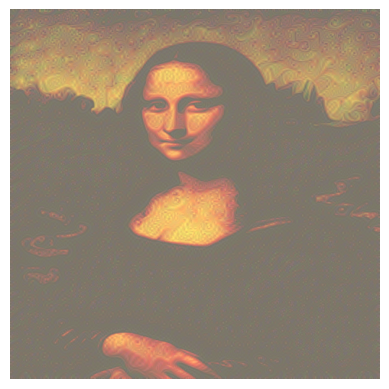

In [16]:
# Run style transfer
content_image_path = './images/rect/original.png'
style_image_path = './images/rect/style.png'

# Generate the stylized image
stylized_image = style_transfer(content_image_path, style_image_path)

# Display the result
plt.imshow(stylized_image)
plt.axis('off')
plt.show()

# Save the result
kp_image.save_img(f'./images/export/stylized_image-{var_iterations}_iterations.png', stylized_image)